In [1]:
!pip install yellowbrick

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
%matplotlib inline 
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import AgglomerativeClustering
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from itertools import cycle
from yellowbrick.cluster import KElbowVisualizer

## Importing and cleaning data

In [3]:
# Import data and clean up dataframe
data = pd.read_csv('irisdata.txt', sep = ',', header = None)
data.columns = ['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width', 'Species']
data.at[34, 'Petal Width'] = 0.2
data.at[37, 'Sepal Width'] = 3.6
data.at[37, 'Petal Length'] = 1.4

## Elbow Plot

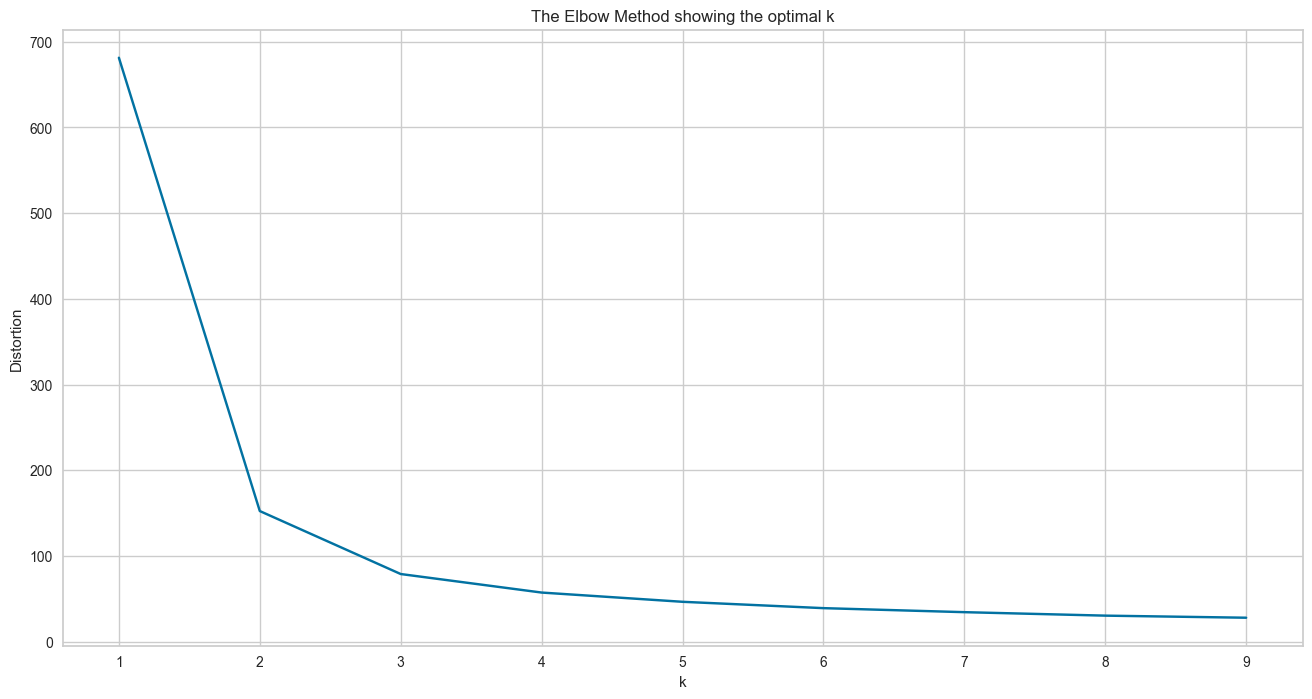

In [4]:
# Create an elbow plot using k-means 
distortions = []
K = range(1,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(data.loc[:, data.columns != 'Species'])
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

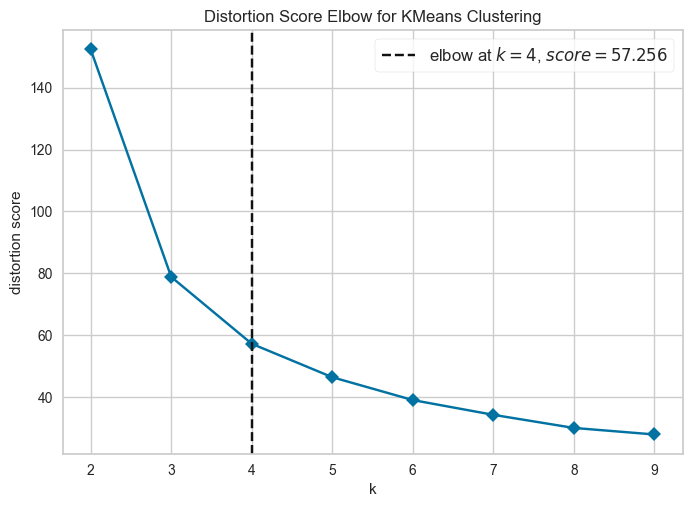

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [5]:
# create an elbow plot using KElbowVisualizer from the yellowbrick package
# default metric: distortion
visualizer1 = KElbowVisualizer(KMeans(),k=(2,10),timings=False)

visualizer1.fit(data.loc[:, data.columns != 'Species'])
visualizer1.show()



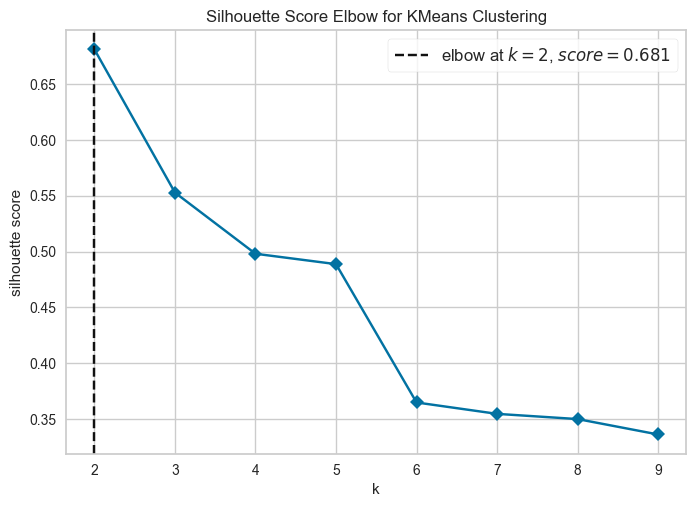

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [7]:
# metric 2: silhouette
visualizer2 = KElbowVisualizer(KMeans(),k=(2,10),metric='silhouette',timings=False)

visualizer2.fit(data.loc[:, data.columns != 'Species'])
visualizer2.show()

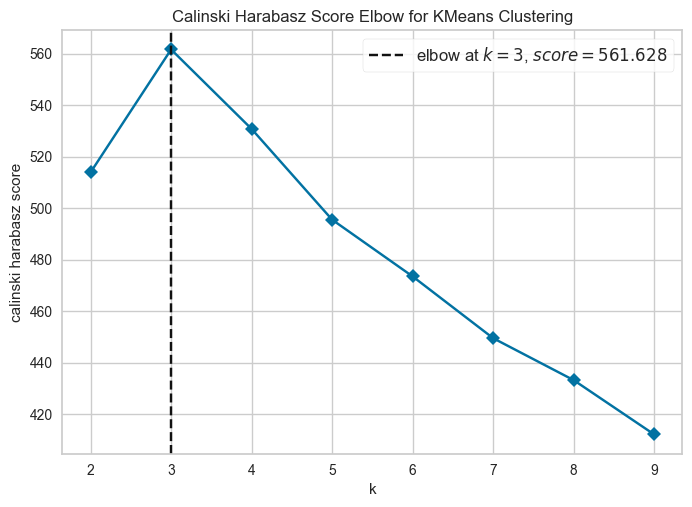

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [8]:
# metric 3: calinski_harabasz
visualizer3 = KElbowVisualizer(KMeans(),k=(2,10),metric='calinski_harabasz',timings=False)

visualizer3.fit(data.loc[:, data.columns != 'Species'])
visualizer3.show()

## PCA

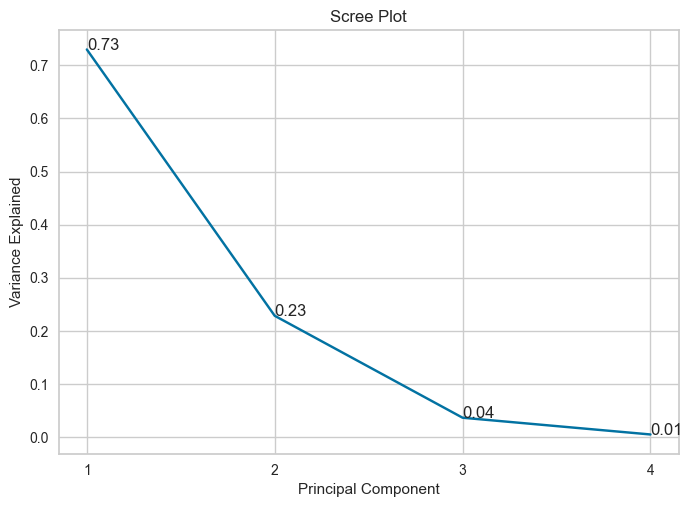

In [17]:
#SCREE plot to determine how many components to use
features = data[['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width']]
scaled_features = StandardScaler().fit_transform(features)
scree_pca = PCA(n_components=4)
scree_fit = scree_pca.fit(scaled_features)

PC_values = np.arange(scree_pca.n_components_) + 1

plt.plot(PC_values,scree_pca.explained_variance_ratio_)
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.xticks(ticks=[1,2,3,4])
plt.ylabel('Variance Explained')
for a,b in zip(PC_values,scree_pca.explained_variance_ratio_):
    plt.text(a,b, str(round(b,2)))
plt.show()

As shown with our scree plot, PC4 only explains ~1% of the variance, so we can explain 99% of our variance using only 3 features.

In [45]:
# Reduce dataframe using PCA
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(scaled_features)
pca_df = pd.DataFrame(principalComponents,columns=['PC1','PC2','PC3'])
pca_df.head()

,PC1,PC2,PC3
0,-2.264703,0.480027,-0.127706
1,-2.080961,-0.674134,-0.234609
2,-2.364229,-0.341908,0.044201
3,-2.299384,-0.597395,0.091290
4,-2.389842,0.646835,0.015738


In [47]:
# 2d scatter plot of PCA
fig = px.scatter(pca_df, x='PC1', y='PC2', color=data['Species'])
fig.show()

In [48]:
# 3d plot of PCA
px.scatter_3d(pca_df, x='PC1', y='PC2', z='PC3', color = data['Species'], color_discrete_sequence = px.colors.qualitative.Prism,
             title = 'PCA 3d Plot')

## K-Means Clustering

In [21]:
k_x = data.loc[:, data.columns != 'Species'].values
k_y = data.loc[:, data.columns == 'Species'].values

In [22]:
kmeans = KMeans(n_clusters=3, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
y_kmeans = kmeans.fit_predict(k_x)
k_centers = kmeans.cluster_centers_
k_n_clusters = len(k_centers)
k_labels = kmeans.predict(k_x)

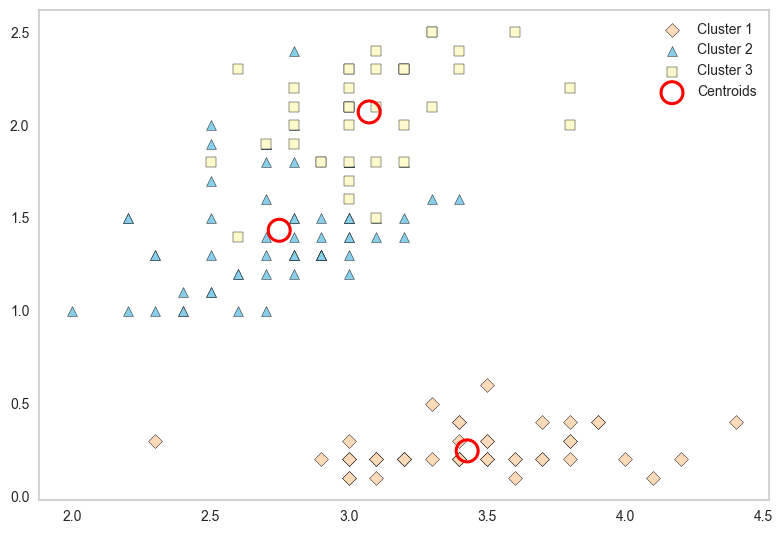

In [23]:
# 2d scatter plot of K-Means Clustering
plt.scatter(k_x[y_kmeans == 0, 1], k_x[y_kmeans == 0, 3], s=50,
           c='peachpuff', marker='D', edgecolor='black', label='Cluster 1')
plt.scatter(k_x[y_kmeans == 1, 1], k_x[y_kmeans == 1, 3], s=50,
           c='skyblue', marker='^', edgecolor='black', label='Cluster 2')
plt.scatter(k_x[y_kmeans == 2, 1], k_x[y_kmeans == 2, 3], s=50,
           c='lemonchiffon', marker='s', edgecolor='black', label='Cluster 3')
plt.scatter(k_centers[:,1], k_centers[:, 3], s=250,
           marker='o', edgecolor='red', linewidth=2.2, facecolor='none', label='Centroids')
plt.legend(scatterpoints=1)
plt.grid()
plt.tight_layout()
plt.show()

In [24]:
# vectorize y species values to calculate statistics
d = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
k_y = k_y.flatten()
k_y = np.vectorize(d.get)(k_y)

In [25]:
print('Estimated number of clusters: %d' % k_n_clusters)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(k_y, k_labels))
print("Completeness: %0.3f" % metrics.completeness_score(k_y, k_labels))
print("V-measure: %0.3f" % metrics.v_measure_score(k_y, k_labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(k_y, k_labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(k_y, k_labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(k_x, k_labels, metric='sqeuclidean'))

Estimated number of clusters: 3
Homogeneity: 0.751
Completeness: 0.765
V-measure: 0.758
Adjusted Rand Index: 0.730
Adjusted Mutual Information: 0.755
Silhouette Coefficient: 0.736


## Affinity Propogation

In [27]:
affinity_x = data.loc[:, data.columns != 'Species'].values
affinity_y = data.loc[:, data.columns == 'Species'].values
ap = AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True, damping=0.5, max_iter=200, 
                         preference=-20, verbose=False, random_state=0)
ap.fit(affinity_x)
y_affinity = ap.fit_predict(affinity_x)
a_centers = ap.cluster_centers_
a_indices = ap.cluster_centers_indices_
a_n_clusters = len(a_centers)
a_labels = ap.predict(affinity_x)

ValueError: ndarray is not C-contiguous

In [ ]:
plt.scatter(affinity_x[:, 0], affinity_x[:, 1], c=a_labels, s=50)

In [ ]:
plt.close("all")
plt.figure(1, figsize=[10,6])
plt.clf()

colors = cycle("bgrcmykbgrcmykbgrcmykbgrcmyk")
for k, col in zip(range(a_n_clusters), colors):
    class_members = a_labels == k
    cluster_center = affinity_x[a_indices[k]]
    plt.plot(affinity_x[class_members, 0], affinity_x[class_members, 1], col + ".")
    plt.plot(
        cluster_center[0],
        cluster_center[1],
        "o",
        markerfacecolor=col,
        markeredgecolor="k",
        markersize=14,
    )
    for x in affinity_x[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title("Estimated number of clusters: %d" % a_n_clusters)
plt.show()

In [ ]:
# vectorize y species values to calculate statistics
d = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
affinity_y = affinity_y.flatten()
affinity_y = np.vectorize(d.get)(affinity_y.flatten())

In [ ]:
# Statistics for Affinity Propagation

print('Estimated number of clusters: %d' % a_n_clusters)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(affinity_y, a_labels))
print("Completeness: %0.3f" % metrics.completeness_score(affinity_y, a_labels))
print("V-measure: %0.3f" % metrics.v_measure_score(affinity_y, a_labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(affinity_y, a_labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(affinity_y, a_labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(affinity_x, a_labels, metric='sqeuclidean'))